# hicstuff API demo

All steps of hicstuff pipeline and downstream operations can be ran using the python api. The matrix can be generated directly from the reads, just like in the command line or by doing each step separately for fine control.


## Data preparation
If using minimap2, the genome can be in fasta format. If using bowtie2, it must be indexed using bowtie2-build:
```bash
bowtie2-build genome.fasta genome
```
The input reads can be in fastq format, or if already aligned to the genome in SAM/BAM format. The pipeline also accepts input in the form of pairs file. The input format is specified using the `start_stage` argument (fastq/sam/pairs/pairs_idx).

## Full pipeline using the API
The hicstuff.pipeline submodule allows to run all steps at one, in a way identical to the hicstuff pipeline command. Here we assume the reads have been aligned and converted to a pairs file already by specifying `start_stage='pairs'`, but it is also possible to give fastq files or sam files as input by specifying `start_stage='fastq'` or `start_stage='sam'`.

In [204]:
import hicstuff.pipeline as hpi

# Generating matrix from dummy dataset
hpi.full_pipeline(input1='../../test_data/valid.pairs', 
                  input2=None, 
                  genome='../../test_data/genome/seq', 
                  enzyme="DpnII",
                  filter_events=True, 
                  pcr_duplicates=True, 
                  start_stage='pairs')


INFO :: ## hicstuff: v1.4.4 log file
INFO :: ## date: 2019-07-17 16:48:36
INFO :: ## enzyme: DpnII
INFO :: ## input1: ../../test_data/valid.pairs 
INFO :: ## input2: None
INFO :: ## ref: ../../test_data/genome/seq
INFO :: ---
INFO :: Filtering with thresholds: uncuts=6 loops=5
INFO :: Proportion of inter contacts: 1.97% (intra: 298, inter: 6)
INFO :: 9696 pairs discarded: Loops: 31, Uncuts: 9663, Weirds: 2
INFO :: 304 pairs kept (3.04%)
INFO :: 0% PCR duplicates have been filtered out (0 / 304 pairs) 
INFO :: 304 pairs used to build a contact map of 564 bins with 304 nonzero entries.
INFO :: Contact map generated after 0h 0m 0s


## Visualise output files

The temporary pairs files can be used to visualise the probability of contacts over genomic distance (distance law). Functions in the view module can also be used to generate visualisations of the results. The utilities in the hicstuff module are handy to transform the matrix.

<IPython.core.display.Javascript object>


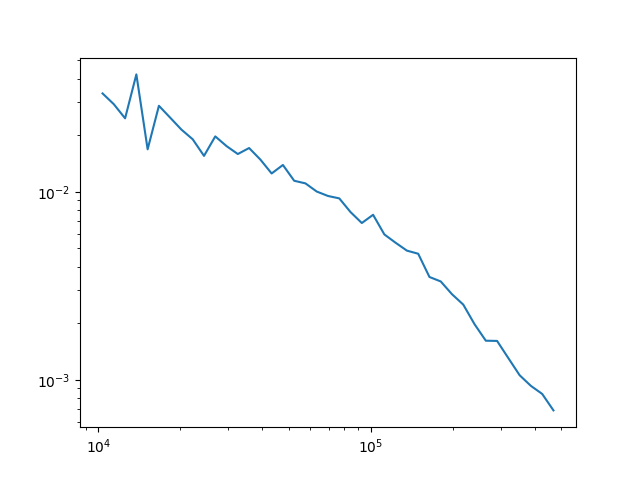

In [8]:
%matplotlib notebook
from importlib import reload
import hicstuff.distance_law as hdl
from matplotlib import pyplot as plt
reload(hdl)
xs, ps, names = hdl.get_distance_law('example_data/example_clean.pairs', 'example_data/fragments_list.txt')
# Normalize P(s) to sum to 1 between
ps = hdl.normalize_distance_law(xs, ps)
# Extract first chromosome only
chrom_xs, chrom_ps, chrom_name = xs[0], ps[0], names[0]
# Select interactions between 10 and 500kb
bp_range = (chrom_xs > 10000) & (chrom_xs < 500000)
# Plot log probability of contact versus log genomic distance
plt.loglog(chrom_xs[bp_range], chrom_ps[bp_range])

Common operations for processing Hi-C matrices are made available in hicstuff. These operations work on scipy sparse matrices.

  self[i, j] = values



<IPython.core.display.Javascript object>


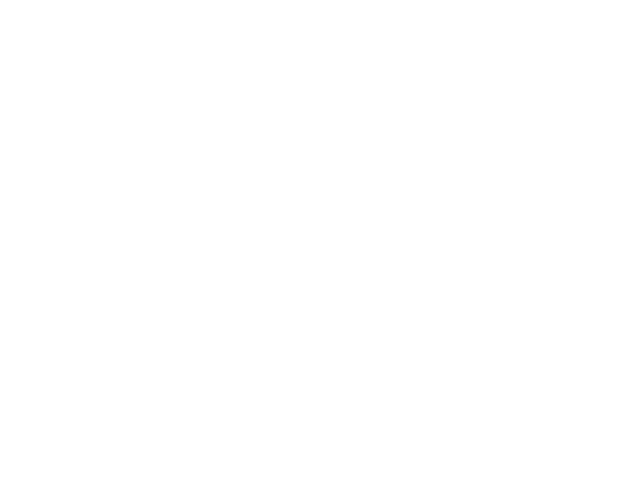

In [6]:
%matplotlib notebook
from hicstuff import hicstuff as hcs
import hicstuff.view as hcv
import hicstuff.io as hio
from scipy.sparse import csr_matrix
from scipy.ndimage import gaussian_filter
import numpy as np
# Load COO sparse matrix from text file
sparse_mat = hio.load_sparse_matrix('example_data/abs_fragments_weighted.txt')
# Normalize matrix so that each genomic bin is equally covered
norm_mat = hcs.normalize_sparse(sparse_mat)
# Remove outlier bins with very little contacts
trim_mat = hcs.trim_sparse(norm_mat)
# Remove "speckles" (outlier pixel values) to reduce noise
clean_mat = hcs.despeckle_simple(trim_mat)
# Show the matrix
dense_mat = hcv.sparse_to_dense(clean_mat, remove_diag=False)
# Add some blur to the matrix :)
blurred_mat = gaussian_filter(dense_mat, 1.1)
# Plot blurred matrix
hcv.plot_matrix(blurred_mat, vmax=0.05)

<IPython.core.display.Javascript object>


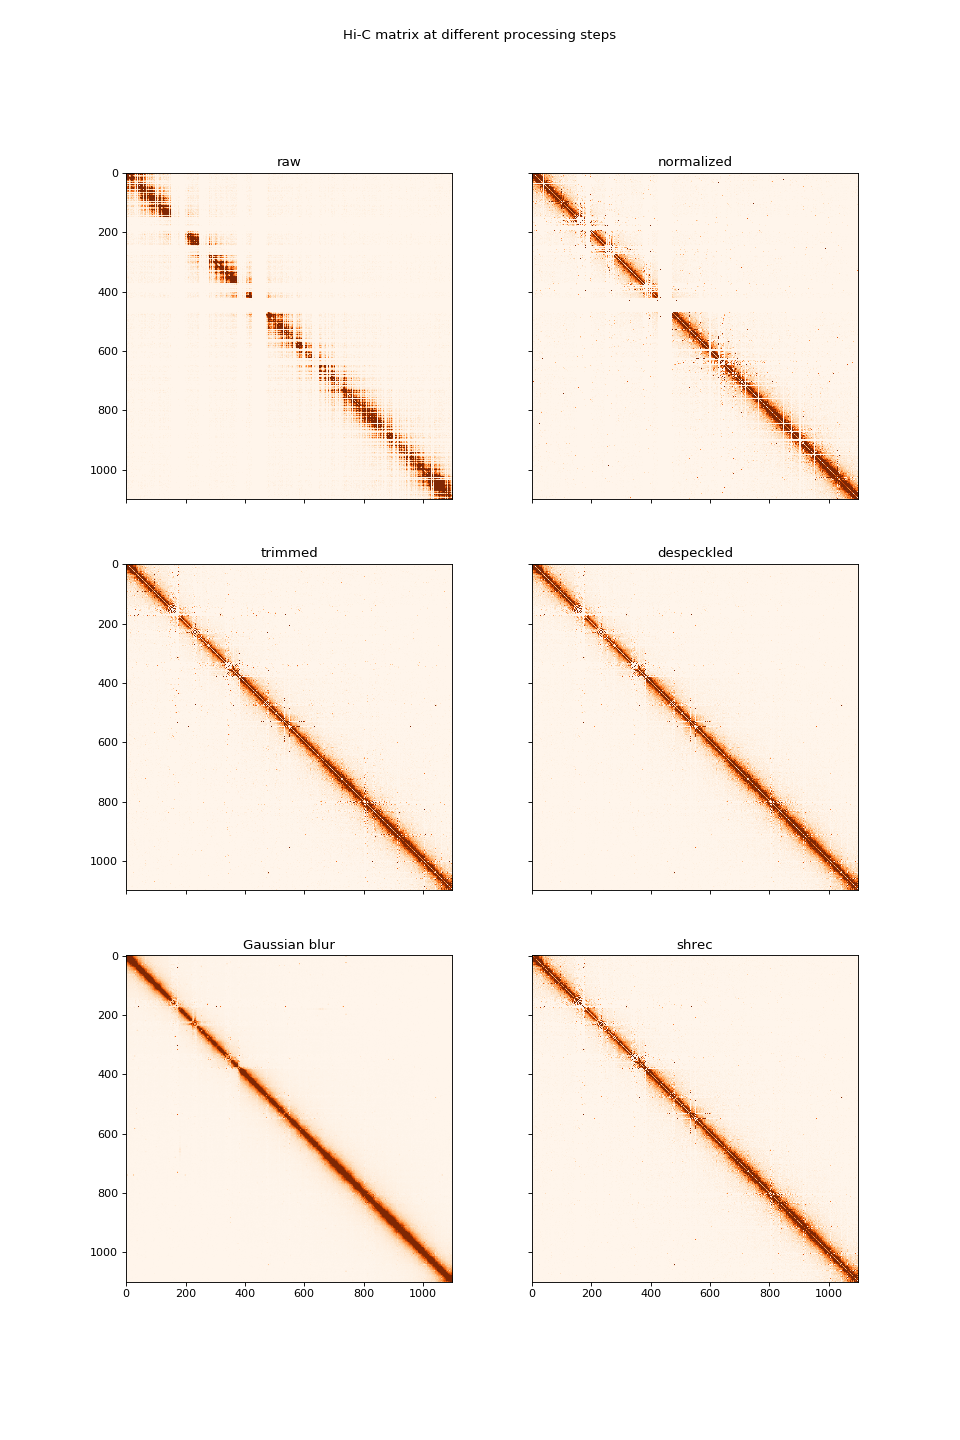

Text(0.5, 0.98, 'Hi-C matrix at different processing steps')

In [13]:
%matplotlib notebook
from matplotlib import pyplot as plt

# Visualize matrix at each different steps
todense = lambda x: hcv.sparse_to_dense(x, remove_diag=False)
mats = [
    ('raw',         todense(sparse_mat)),
    ('normalized',  todense(norm_mat)),
    ('trimmed',     todense(trim_mat)),
    ('despeckled',  todense(clean_mat)),
    ('Gaussian blur', blurred_mat),
    ('shrec',       hcs.shortest_path_interpolation(dense_mat, alpha=0.04, strict=True))
]

fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(12, 18), dpi=80)
for i, axi in enumerate(ax.flatten()):
    axi.set_aspect(1)
    axi.set_title(mats[i][0])
    axi.imshow(mats[i][1], cmap="Oranges", vmax=np.percentile(mats[i][1], 98.5))    
    
plt.suptitle("Hi-C matrix at different processing steps")


### Rebinning
It is also possible to rebin an existing matrix to a lower resolution. There are two types of binning in hicstuff: Base-pair binning where bins are of fixed genomic size, and subsample binning where new bins are formed by grouping N bins together.

In [18]:
# Load COO sparse matrix at 1kb resolution
sparse_mat_1kb = hio.load_sparse_matrix('example_data/abs_fragments_weighted.txt')

# Rebin by subsampling groups of 5 fragments
mat_sub_5 = hcs.bin_sparse(sparse_mat_1kb, 5)

# Rebin by basepairs at 5kb. Genomic positions of fragments are required for this !
# Load start positions of fragments from fragments_list file
frags_start = hio.load_pos_col('example_data/fragments_list.txt', 2)
mat_5kb, frags_5kb = hcs.bin_bp_sparse(sparse_mat_1kb, frags_start, 5000)

<IPython.core.display.Javascript object>


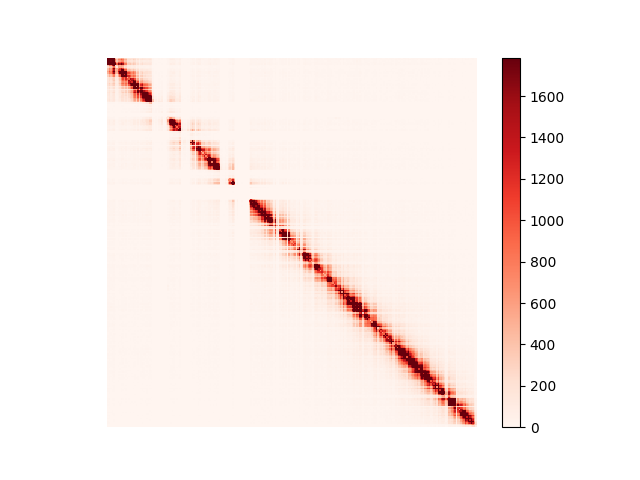

<IPython.core.display.Javascript object>


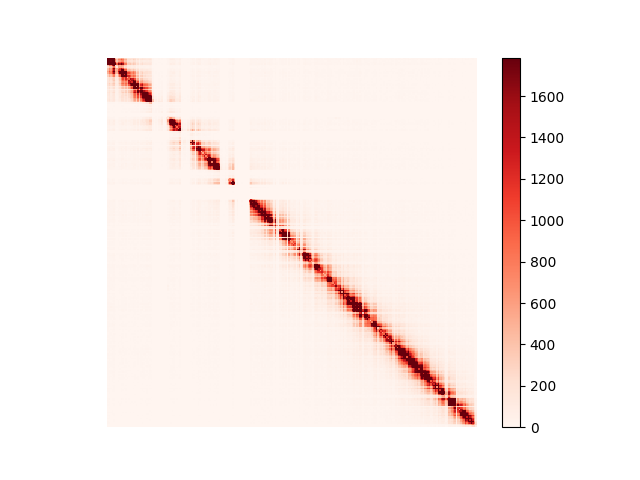

In [19]:
# Plotting matrix with both binning strategies
hcv.plot_matrix(hcv.sparse_to_dense(mat_5kb, remove_diag=False))
hcv.plot_matrix(hcv.sparse_to_dense(mat_sub_5, remove_diag=False))

### Exporting

Processed matrices can be exported form python to a file.

In [21]:
# Export sparse matrix
hio.save_sparse_matrix(mat_5kb, '5kb_matrix.txt')

# Export dense matrix
dense_5kb = hcv.sparse_to_dense(mat_5kb, remove_diag=False)
np.savetxt('5kb_dense_matrix.txt', dense_5kb)

## Playing with formats

The contact map and fragments table can be used to generate a cool file using the `hicstuff.io.save_cool` command. Symmetrically, the `hicstuff.io.load_cool` command can be used to load the matrix and fragments list from a cool file.

In [202]:
import pandas as pd
frags = pd.read_csv('example_data/fragments_list.txt', sep='\t')

hio.save_cool('example.cool', sparse_mat, frags)

INFO :: Creating cooler at "example.cool::/"
INFO :: Writing chroms
INFO :: Writing bins
INFO :: Writing pixels
INFO :: Writing indexes
INFO :: Writing info
INFO :: Done
